In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import cv2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, Concatenate, Flatten
from google.colab import drive
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Paths to your dataset in Google Drive
video_folder = '/content/drive/MyDrive/RealLifeDeceptionDetection.2016/Real-life_Deception_Detection_2016/Clips'
transcription_folder = '/content/drive/MyDrive/RealLifeDeceptionDetection.2016/Real-life_Deception_Detection_2016/Transcription'
gesture_annotation_file = '/content/drive/MyDrive/RealLifeDeceptionDetection.2016/Real-life_Deception_Detection_2016/Annotation/All_Gestures_Deceptive and Truthful.csv'

In [ ]:
# Load gesture annotations
gesture_annotations = pd.read_csv(gesture_annotation_file)

# Inspect the columns of the gesture_annotations DataFrame
print(gesture_annotations.columns)

Index(['id', 'OtherGestures', 'Smile', 'Laugh', 'Scowl',
       'otherEyebrowMovement', 'Frown', 'Raise', 'OtherEyeMovements',
       'Close-R', 'X-Open', 'Close-BE', 'gazeInterlocutor', 'gazeDown',
       'gazeUp', 'otherGaze', 'gazeSide', 'openMouth', 'closeMouth',
       'lipsDown', 'lipsUp', 'lipsRetracted', 'lipsProtruded', 'SideTurn',
       'downR', 'sideTilt', 'backHead', 'otherHeadM', 'sideTurnR', 'sideTiltR',
       'waggle', 'forwardHead', 'downRHead', 'singleHand', 'bothHands',
       'otherHandM', 'complexHandM', 'sidewaysHand', 'downHands', 'upHands',
       'class'],
      dtype='object')


In [ ]:
# Assuming the first column is the clip ID, and the last column is the label
clip_id_column = gesture_annotations.columns[0]
label_column = gesture_annotations.columns[-1]

# Initialize pre-trained CNN for video feature extraction
cnn_model = VGG16(weights='imagenet', include_top=False)
cnn_model = Model(inputs=cnn_model.input, outputs=Flatten()(cnn_model.output))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
# Function to extract video features
def extract_video_features(video_path, cnn_model, fixed_frame_count=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    count = 0

    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return None

    while cap.isOpened() and count < fixed_frame_count:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224))  # Resize frame to fit VGG16 input
        frames.append(frame)
        count += 1

    cap.release()

    if len(frames) == 0:
        print(f"Error: No frames extracted from video file {video_path}")
        return None

    # Pad frames if less than fixed_frame_count
    while len(frames) < fixed_frame_count:
        frames.append(np.zeros((224, 224, 3), dtype='float32'))

    frames = np.array(frames)

    # Preprocess frames for VGG16
    frames = frames.astype('float32')
    frames = frames / 255.0  # Normalize pixel values

    # Extract features using the CNN
    features = cnn_model.predict(frames)

    # Average features across frames
    video_features = np.mean(features, axis=0)

    return video_features

In [ ]:
# Function to load and preprocess text data
def load_and_preprocess_text(transcription_path):
    if not os.path.exists(transcription_path):
        print(f"Error: Transcription file {transcription_path} does not exist.")
        return ""

    with open(transcription_path, 'r') as file:
        text = file.read()
    return text

In [ ]:
# Initialize lists for dataset
video_features = []
text_data = []
gesture_data = []
labels = []

In [ ]:
# Load dataset
for idx, row in gesture_annotations.iterrows():
    clip_id = row[clip_id_column]
    video_file = os.path.join(video_folder, clip_id)
    transcription_file = os.path.join(transcription_folder, clip_id.replace('.mp4', '.txt'))

    # Extract video features
    video_feat = extract_video_features(video_file, cnn_model)
    if video_feat is not None:
        video_features.append(video_feat)
    else:
        print(f"Skipping {video_file} due to extraction issues.")
        continue

    # Load and preprocess text
    text = load_and_preprocess_text(transcription_file)
    if text:
        text_data.append(text)
    else:
        print(f"Skipping {transcription_file} due to loading issues.")
        continue

    # Get gesture data
    gestures = row[1:-1].values  # Adjust index slicing if necessary
    gesture_data.append(gestures)

    # Get label
    label = row[label_column]
    labels.append(label)

# Ensure all entries in text_data are strings
text_data = [str(text) for text in text_data]


1/1 [==============================] - 16s 16s/step
Error: Could not open video file /content/drive/MyDrive/RealLifeDeceptionDetection.2016/Real-life_Deception_Detection_2016/Clips/trial_lie_051.mp4
Skipping /content/drive/MyDrive/RealLifeDeceptionDetection.2016/Real-life_Deception_Detection_2016/Clips/trial_lie_051.mp4 due to extraction issues.
Error: Could not open video file /content/drive/MyDrive/RealLifeDeceptionDetection.2016/Real-life_Deception_Detection_2016/Clips/trial_lie_052.mp4
Skipping /content/drive/MyDrive/RealLifeDeceptionDetection.2016/Real-life_Deception_Detection_2016/Clips/trial_lie_052.mp4 due to extraction issues.
Error: Could not open video file /content/drive/MyDrive/RealLifeDeceptionDetection.2016/Real-life_Deception_Detection_2016/Clips/trial_lie_053.mp4
Skipping /content/drive/MyDrive/RealLifeDeceptionDetection.2016/Real-life_Deception_Detection_2016/Clips/trial_lie_053.mp4 due to extraction issues.
Error: Could not open video file /content/drive/MyDrive/Real

In [ ]:
# Convert string labels to integers
label_map = {'deceptive': 0, 'truthful': 1}
labels = [label_map[label] for label in labels]
# Convert lists to numpy arrays if they are not empty
if len(video_features) > 0:
    video_features = np.array(video_features, dtype='float32')
if len(gesture_data) > 0:
    gesture_data = np.array(gesture_data, dtype='float32')
if len(labels) > 0:
    labels = np.array(labels, dtype='int32')

In [ ]:
# Tokenize and pad text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)
word_index = tokenizer.word_index
text_data = pad_sequences(sequences, maxlen=100)  # MAX_SEQUENCE_LENGTH
text_data = np.array(text_data, dtype='float32')

In [ ]:
# Check shapes and data types
print("Video features shape:", video_features.shape, "dtype:", video_features.dtype)
print("Text data shape:", text_data.shape, "dtype:", text_data.dtype)
print("Gesture data shape:", gesture_data.shape, "dtype:", gesture_data.dtype)
print("Labels shape:", labels.shape, "dtype:", labels.dtype)

Video features shape: (100, 25088) dtype: float32
Text data shape: (100, 100) dtype: float32
Gesture data shape: (100, 39) dtype: float32
Labels shape: (100,) dtype: int32


In [ ]:
# Simplified model for initial testing
text_input = Input(shape=(100,), name='text_input')  # MAX_SEQUENCE_LENGTH
embedding = Embedding(len(word_index) + 1, 100)(text_input)  # EMBEDDING_DIM
rnn_output = LSTM(128)(embedding)
gesture_input = Input(shape=(gesture_data.shape[1],), name='gesture_input')
video_input = Input(shape=(video_features.shape[1],), name='video_input')

merged = Concatenate()([video_input, rnn_output, gesture_input])
dense = Dense(128, activation='relu')(merged)
output = Dense(2, activation='softmax')(dense)  # NUM_CLASSES

model = Model(inputs=[video_input, text_input, gesture_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 100)             133800    ['text_input[0][0]']          
                                                                                                  
 video_input (InputLayer)    [(None, 25088)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  117248    ['embedding[0][0]']           
                                                                                            

In [ ]:
# Example training (use actual data instead of placeholders)
history=model.fit([video_features, text_data, gesture_data], labels, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 1s 444ms/step - loss: 1.8654e-04 - accuracy: 1.0000 - val_loss: 2.2981 - val_accuracy: 0.5500
Epoch 2/30
3/3 [==============================] - 2s 638ms/step - loss: 1.7410e-04 - accuracy: 1.0000 - val_loss: 2.3235 - val_accuracy: 0.5500
Epoch 3/30
3/3 [==============================] - 1s 397ms/step - loss: 1.6337e-04 - accuracy: 1.0000 - val_loss: 2.3459 - val_accuracy: 0.5000
Epoch 4/30
3/3 [==============================] - 1s 476ms/step - loss: 1.5192e-04 - accuracy: 1.0000 - val_loss: 2.3631 - val_accuracy: 0.5000
Epoch 5/30
3/3 [==============================] - 1s 434ms/step - loss: 1.4269e-04 - accuracy: 1.0000 - val_loss: 2.3779 - val_accuracy: 0.5000
Epoch 6/30
3/3 [==============================] - 1s 171ms/step - loss: 1.3264e-04 - accuracy: 1.0000 - val_loss: 2.3945 - val_accuracy: 0.5000
Epoch 7/30
3/3 [==============================] - 1s 187ms/step - loss: 1.2450e-04 - accuracy: 1.0000 - val_loss: 2.4089 - val_accuracy:

In [ ]:
# Evaluate the model and calculate precision, recall, and f1 score
from sklearn.metrics import accuracy_score
def evaluate_model(model, video_features, text_data, gesture_data, labels):
    predictions = model.predict([video_features, text_data, gesture_data])
    y_pred = np.argmax(predictions, axis=1)
    precision = precision_score(labels, y_pred, average='weighted')
    recall = recall_score(labels, y_pred, average='weighted')
    f1 = f1_score(labels, y_pred, average='weighted')
    accuracy = accuracy_score(labels, y_pred) # Calculate accuracy
    return precision, recall, f1, accuracy


In [ ]:
precision, recall, f1, accuracy = evaluate_model(model, video_features, text_data, gesture_data, labels)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

4/4 [==============================] - 1s 36ms/step
Accuracy: 0.88
Precision: 0.9032258064516128
Recall: 0.88
F1 Score: 0.8782467532467533


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


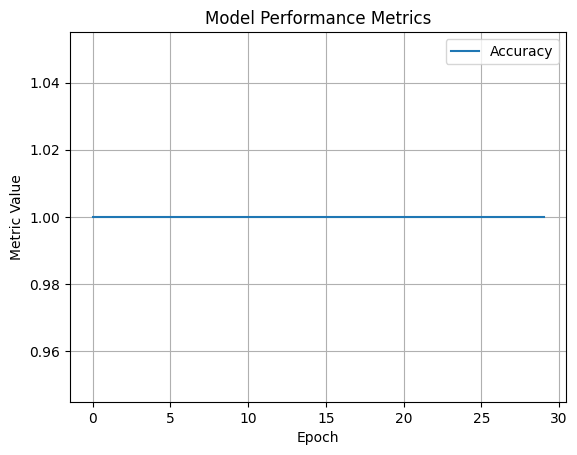

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())

plt.plot(history.history['accuracy'], label='Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Model Performance Metrics')
plt.legend()
plt.grid(True)
plt.show()